In [22]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision

%matplotlib inline
import glob
import os
from math import ceil
import random

import cv2
import PIL
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from typing import *

# importing modules
import urllib.request
from urllib.request import urlopen
from PIL import Image

import bounding_boxes

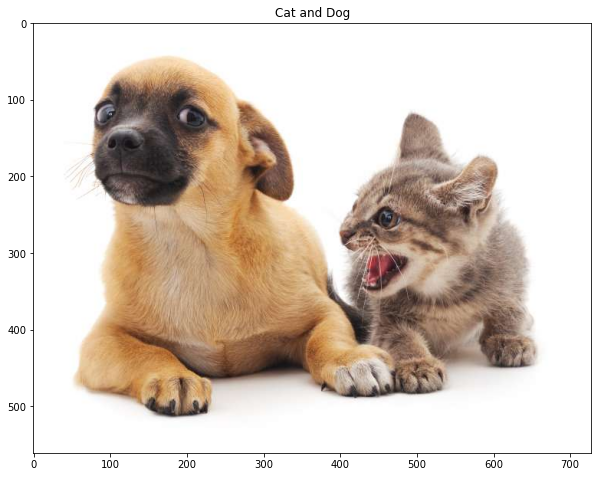

In [12]:
cat_dog_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/catdog.jpg"

# plot cat and dog with title using PIL
plt.figure(figsize=(10, 10))

cat_dog = PIL.Image.open(urlopen(cat_dog_p))
plt.imshow(cat_dog)
plt.title("Cat and Dog")
plt.show();

In [16]:
height, width, channel = np.asarray(cat_dog).shape
print(
    f"The height is {height} and the width is {width} and the channel is {channel}"
)

The height is 561 and the width is 728 and the channel is 3


## Bounding Boxes

In object detection, we usually use a *bounding box* to describe the spatial location of an object. The bounding box is rectangular, which is determined by the $x$ and $y$ coordinates of the upper-left corner of the rectangle and the such coordinates of the lower-right corner. Another commonly used bounding box representation is the $(x, y)$-axis coordinates of the bounding box center, and the width and height of the box.

[**Here we define functions to convert between**] these (**two
representations**):
`box_corner_to_center` converts from the two-corner
representation to the center-width-height presentation,
and `box_center_to_corner` vice versa.
The input argument `boxes` should be a two-dimensional tensor of
shape ($n$, 4), where $n$ is the number of bounding boxes.

### Pascal

https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

pascal_voc is a format used by the Pascal VOC dataset. Coordinates of a bounding box are encoded with four values in pixels: [x_min, y_min, x_max, y_max]. x_min and y_min are coordinates of the top-left corner of the bounding box. x_max and y_max are coordinates of bottom-right corner of the bounding box.

Coordinates of the example bounding box in this format are [98, 345, 420, 462].

### COCO

coco is a format used by the Common Objects in Context 
C
O
C
O
 dataset.

In coco, a bounding box is defined by four values in pixels [x_min, y_min, width, height]. They are coordinates of the top-left corner along with the width and height of the bounding box.

Coordinates of the example bounding box in this format are [98, 345, 322, 117].

In [102]:
def voc2coco(bboxes: torch.Tensor) -> torch.Tensor:
    """Convert pascal_voc to coco format.

    voc  => [xmin, ymin, xmax, ymax]
    coco => [xmin, ymin, w, h]

    Args:
        bboxes (torch.Tensor): Shape of (N, 4) where N is the number of samples and 4 is the coordinates [xmin, ymin, xmax, ymax].

    Returns:
        coco_bboxes (torch.Tensor): Shape of (N, 4) where N is the number of samples and 4 is the coordinates [xmin, ymin, w, h].
    """

    # don't perform in place to avoid mutation
    coco_bboxes = bboxes.clone()
    for index, each_bbox in enumerate(bboxes):
        xmin, ymin, xmax, ymax = each_bbox
        w, h = xmax - xmin, ymax - ymin
        coco_bboxes[index] = torch.tensor([xmin, ymin, w, h])

    return coco_bboxes


def coco2voc(bboxes: torch.Tensor) -> torch.Tensor:
    """Convert coco to pascal_voc format.

    coco => [xmin, ymin, w, h]
    voc  => [xmin, ymin, xmax, ymax]


    Args:
        bboxes (torch.Tensor): Shape of (N, 4) where N is the number of samples and 4 is the coordinates [xmin, ymin, w, h].

    Returns:
        voc_bboxes (torch.Tensor): Shape of (N, 4) where N is the number of samples and 4 is the coordinates [xmin, ymin, xmax, ymax].
    """

    # don't perform in place to avoid mutation
    voc_bboxes = bboxes.clone()
    for index, each_bbox in enumerate(bboxes):
        xmin, ymin, w, h = each_bbox
        xmax, ymax = xmin + w, ymin + h
        voc_bboxes[index] = torch.tensor([xmin, ymin, xmax, ymax])

    return voc_bboxes


In [103]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
bboxes = torch.tensor((dog_bbox, cat_bbox))
bboxes

tensor([[ 60.,  45., 378., 516.],
        [400., 112., 655., 493.]])

In [104]:
coco2voc(voc2coco(bboxes))

tensor([[ 60.,  45., 378., 516.],
        [400., 112., 655., 493.]])

In [105]:
a = voc2coco(bboxes)
b = coco2voc(a)

In [106]:
a, b

(tensor([[ 60.,  45., 318., 471.],
         [400., 112., 255., 381.]]),
 tensor([[ 60.,  45., 378., 516.],
         [400., 112., 655., 493.]]))

We measure the bounding box coordinates for the cat and dog respectively. Here `bbox` is the abbreviation for bounding box.

The `bbox` below represents 

```python
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
```

In [123]:
def draw_bboxes_on_single_image(
    image: Union[torch.Tensor, np.ndarray],
    bboxes: Union[torch.Tensor, np.ndarray],
    labels: List[int],
    colors: Dict[int, Tuple[int, int, int]],
) -> np.ndarray:
    """Draws bounding boxes on a single image.

    Args:
        image (Union[torch.Tensor, np.ndarray]): The original image to draw on.
        bboxes (Union[torch.Tensor, np.ndarray]): The bounding boxes of the original image.
        labels (List[int]): The labels of the bounding boxes corresponding to the bounding boxes. Note they are needed to be in the same order as the bounding boxes.
        colors (Dict[int, Tuple[int, int, int]]): The color mapping of the labels.

    Returns:
        image (np.ndarray): The image with bounding boxes drawn on it.

    Example:
        >>> import torch
        >>> import numpy as np
        >>> cat_dog_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/catdog.jpg"
        >>> cat_dog = PIL.Image.open(urlopen(cat_dog_p))
        >>> dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
        >>> bboxes = torch.tensor((dog_bbox, cat_bbox))
        >>> labels = [0, 1]
        >>> colors = {0: (255, 0, 255), 1: (0, 255, 255)}
        >>> bbox_img = draw_bboxes_on_single_image(cat_dog, bboxes, labels=labels, colors=colors)
        >>> plt.imshow(bbox_img)
    """

    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()

    # make sure it is in np.ndarray format if read as PIL
    image = np.asarray(image.copy())

    for i, bbox in enumerate(bboxes):
        color = colors[labels[i]]
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        image = cv2.rectangle(
            image.copy(), pt1, pt2, color, int(max(image.shape[:2]) / 200)
        )

    return image

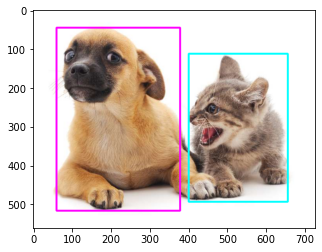

In [125]:
>>> import torch
>>> import numpy as np
>>> cat_dog_p = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/deep_learning/computer_vision/data/misc/catdog.jpg"
>>> cat_dog = PIL.Image.open(urlopen(cat_dog_p))
>>> dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
>>> bboxes = torch.tensor((dog_bbox, cat_bbox))
>>> labels = [0, 1]
>>> colors = {0: (255, 0, 255), 1: (0, 255, 255)}
>>> bbox_img = draw_bboxes_on_single_image(cat_dog, bboxes, labels=labels, colors=colors)
>>> plt.imshow(bbox_img);

## Anchor Boxes

In [126]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)